In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 65.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/6

---
Load Libraries

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-3-465a1193f71c>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

---
Set Global Variables

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "BiLSTM",
    "sem-space": 'attr',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 42, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 12, 
    "overlap": 10,
    "freq": 50,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-9-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-2


---
Load Data

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def load_attribute(fpath):
    with open(fpath, "r") as pf:
        json_data = json.load(pf)

    activity_dict = json_data["Activity"]
    attribute_dict = json_data["Attribute"]
    attr_met = np.array(list(json_data["Mark"].values()))
    return activity_dict, attribute_dict, attr_met

In [ ]:
# load video dataset
Attr_data_path  = data_root+'/Attribute/PAMAP2_attributes.json'
activity_dict, attribute_dict, attr_mat = load_attribute(Attr_data_path)
_, attr_size = attr_mat.shape

---
Utils

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")


In [ ]:
## IMU Dataset

class IMUDataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes):
        super(IMUDataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]
    
    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [ ]:
## IMU Encoder Model

class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [ ]:
def loss_cross_entropy( y_pred, cls, selected_features, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    num_classes = selected_features.size()[0]
    y_pred_trans = torch.transpose(y_pred, 0, 1)
    feat = torch.unsqueeze(selected_features, -1).repeat((1,1,32))
    # print("feat < ", feat.shape, " y_pred_trans < ", y_pred_trans.shape)
    cosineSim = torch.abs(torch.transpose(F.cosine_similarity(feat, y_pred_trans), 0, 1))
    reg = nn.PairwiseDistance(p=2)
    l2Size = torch.unsqueeze(reg(y_pred, y_pred),1)
    simLoss = loss_fn(torch.abs(cosineSim)*l2Size, cls)
    return simLoss

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(y_pred, selected_features):
    num_classes = selected_features.size()[0]
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset, optimizer, loss_module, device, phase='train', loss_alpha=0.7):
    model = model.train()
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0, "accuracy": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss

            class_output = predict_class(feat_output, semantic_space)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] = loss.item()/N # add total loss of batch
                metrics['feat. loss'] = feat_loss.item()/N
                metrics['classi. loss'] = class_loss.item()/N

            # convert feature vector into action class
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class, normalize=True)
            tepoch.set_postfix(metrics)   
    
    # metrics['accuracy'] = metrics['accuracy']/metrics['samples'] # average loss per sample for whole epoch
    # tepoch.set_postfix(metrics)  
    return metrics

In [ ]:
def eval_step(model, dataloader, dataset, loss_module, device, class_names, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.1):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss
            
            class_output = predict_class(feat_output, semantic_space)

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] += loss.item()/N  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()/N
                metrics['classi. loss'] += class_loss.item()/N

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(class_output.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

---
Run

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.173



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.242



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.345



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.408



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.278



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.433



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.335



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.318



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.426



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.445



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.443



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.048



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.139



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.252



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.231



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

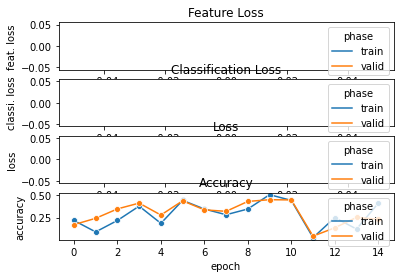

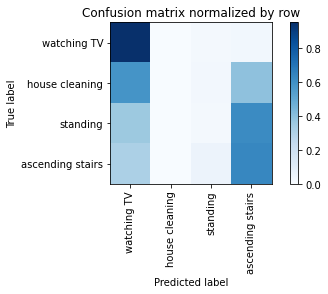

Overall accuracy: 0.270

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.247      0.022      0.040      0.331       1852|	 ascending stairs: 0.620,	watching TV: 0.359,	
  house cleaning       0.000      0.000      0.000      0.329       1840|	 watching TV: 0.585,	ascending stairs: 0.391,	standing: 0.024,	
ascending stairs       0.265      0.633      0.374      0.193       1078|	 watching TV: 0.313,	standing: 0.055,	
     watching TV       0.275      0.951      0.427      0.148        830|	 ascending stairs: 0.028,	standing: 0.022,	

----------------------------------------------------------------------------------------------------
     avg / total       0.174      0.270      0.148        1.0       5600|	      

{'accuracy': 0.26982142857142855, 'precision': 0.19684336447303855, 'recall': 0.40121343575031826, 'f1': 0.21009215711510265, 'samples': 0, 'loss': 47.082720041275024, 'feat. loss': 47.058458134531975, 'classi

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.124



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.293



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.141



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.312



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.314



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.121



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.202



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.294



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.337



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.204



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.354



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.224



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.168



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.207



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.278



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

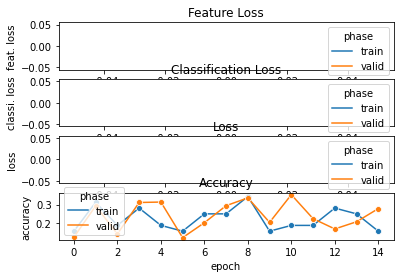

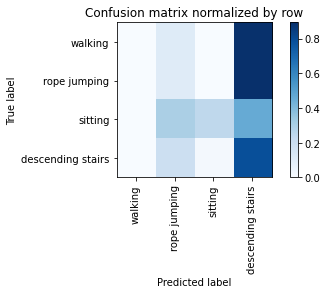

Overall accuracy: 0.223

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.000      0.000      0.000      0.420       2327|	 descending stairs: 0.889,	rope jumping: 0.110,	sitting: 0.001,	
          sitting       0.954      0.244      0.389      0.326       1802|	 descending stairs: 0.458,	rope jumping: 0.297,	
descending stairs       0.184      0.788      0.299      0.171        947|	 rope jumping: 0.192,	sitting: 0.020,	
     rope jumping       0.048      0.107      0.066      0.083        460|	 descending stairs: 0.893,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.346      0.223      0.183        1.0       5536|	      

{'accuracy': 0.22308526011560695, 'precision': 0.2966126195958066, 'recall': 0.28461141801489664, 'f1': 0.18835537074616904, 'samples': 0, 'loss': 40.366963908076286, 'feat. loss': 40.342981427907944,

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.061



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.047



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.052



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.146



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.089



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.112



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.195



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.121



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.222



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.272



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.267



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.265



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.286



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.159



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.244



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

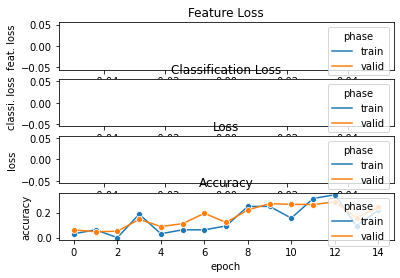

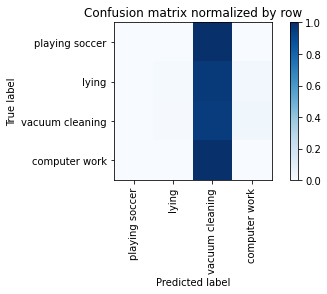

Overall accuracy: 0.233

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.060      0.002      0.004      0.432       3068|	 vacuum cleaning: 0.998,	lying: 0.000,	
          lying       0.587      0.014      0.028      0.264       1874|	 vacuum cleaning: 0.961,	computer work: 0.025,	
vacuum cleaning       0.234      0.952      0.375      0.240       1705|	 computer work: 0.037,	lying: 0.011,	
 playing soccer       0.000      0.000      0.000      0.064        457|	 vacuum cleaning: 1.000,	computer work: 0.000,	lying: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.237      0.233      0.099        1.0       7104|	      

{'accuracy': 0.23324887387387389, 'precision': 0.22015339006140358, 'recall': 0.24214886478608832, 'f1': 0.10198858274359228, 'samples': 0, 'loss': 56.81021396815777, 'feat. loss': 56.779436871409416, 'classi. loss': 307.

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.125



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.116



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.145



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.115



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.227



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.245



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.285



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.179



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.235



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.209



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.296



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.317



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.367



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.431



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

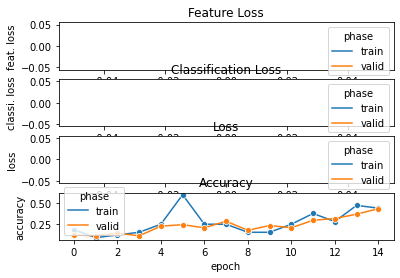

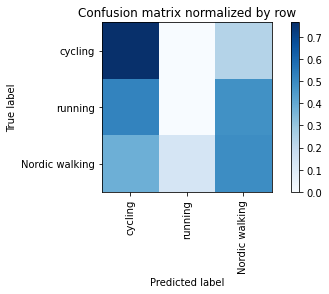

Overall accuracy: 0.486

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.521      0.491      0.506      0.419       1838|	 cycling: 0.379,	running: 0.130,	
       cycling       0.508      0.765      0.611      0.366       1603|	 Nordic walking: 0.235,	running: 0.000,	
       running       0.008      0.002      0.003      0.215        943|	 cycling: 0.520,	Nordic walking: 0.478,	

----------------------------------------------------------------------------------------------------
   avg / total       0.406      0.486      0.436        1.0       4384|	      

{'accuracy': 0.4858576642335766, 'precision': 0.3459224217041618, 'recall': 0.4192292256449104, 'f1': 0.37318050948953346, 'samples': 0, 'loss': 39.089716389775276, 'feat. loss': 39.07466673851013, 'classi. loss': 150.50985431671143}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.148



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.258



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.224



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.194



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.248



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.265



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.260



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.352



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.254



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.280



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.290



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.416



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.392



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.331



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.411



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

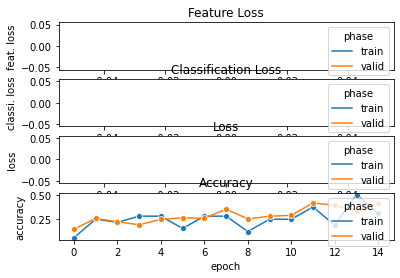

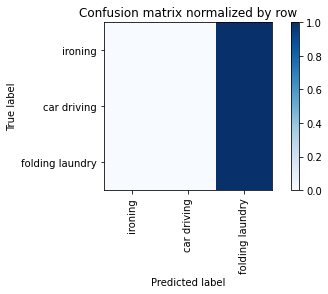

Overall accuracy: 0.254

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       2329|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.254      1.000      0.405      0.254        974|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        537|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.254      0.103        1.0       3840|	      

{'accuracy': 0.25364583333333335, 'precision': 0.08454861111111112, 'recall': 0.3333333333333333, 'f1': 0.13488436504639248, 'samples': 0, 'loss': 33.29630807042122, 'feat. loss': 33.28312590718269, 'classi. loss': 131.83345317840576}
============== Overall Unseen Classes Performance ==============
accuracy          0.293132
precision         0.228816
re

In [ ]:
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.1, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = IMUDataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = IMUDataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = IMUDataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt, optimizer, loss_module, device, phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'seen-eval', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        # if eval_metrics['accuracy'] > best_acc:
        #     best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    # model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()